# NFT Sales Over Time 

Dataset: https://www.kaggle.com/datasets/simiotic/ethereum-nfts

In [3]:
!pip install nfts

In [4]:
!pip install opendatasets

In [29]:
import os
import sqlite3

import matplotlib.pyplot as plt
import nfts.dataset
import numpy as np
import pandas as pd
import opendatasets as od
from datetime import datetime
from matplotlib import pyplot
from scipy import stats

In [30]:
os.listdir('ethereum-nfts')

['.DS_Store', 'nfts.sqlite 2']

In [31]:
DATASET_PATH = "ethereum-nfts/nfts.sqlite 2"

In [32]:
ds = nfts.dataset.FromSQLite(DATASET_PATH)

In [33]:
#Describe the dataset
nfts.dataset.explain()


The Moonstream NFTs dataset

To load the NFTs dataset from a SQLite file, run:
>>> ds = nfts.dataset.FromSQLite(<path to sqlite database>)

This dataset consists of the following dataframes:

Dataframe: nfts
Load using:
	nfts_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "nfts")

Describes the NFT contracts represented in this dataset, with a name and symbol if they were available at time of crawl.

Columns:
1. address: The Ethereum address of the NFT contract.
2. name: The name of the collection of NFTs that the contract represents.
3. symbol: The symbol of the collection of NFTs that the contract represents.

- - -

Dataframe: mints
Load using:
	mints_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "mints")

All token mint events crawled in this dataset.

Columns:
1. event_id: A unique event ID associated with the event.
2. transaction_hash: The hash of the transaction which triggered the event.
3. block_number: The transaction block in which the 

In [35]:
transfers_df = ds.load_dataframe("transfers")

In [ ]:
transfers_df.head()

# How Do NFT Transfers Relate to Time?

In [12]:
#removing transactions worth 0 ETH because 'they may include on-chain transactions that were paid with off-chain assets orthey may purely be a gift' - PwC
transfers_df = transfers_df[transfers_df['transaction_value'] != 0]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [13]:
transfers_df2 = transfers_df.copy()

In [14]:
#add "date" column to the dataframe - remove hour, minute, second data for easier plotting
l = transfers_df2['timestamp'].to_list()

In [15]:
l2 = []
for each in l:
    j = datetime.fromtimestamp(each)
    k = np.datetime64(j)
    k = k.astype('datetime64[D]')
    l2.append(k)

In [16]:
transfers_df2['date'] = l2

In [17]:
#group the transfers by the date they happened
df2 = transfers_df2.groupby(['date'])['date'].count()

In [18]:
df2 = df2.to_frame()
df2 = df2.rename(columns={'date': 'count'})

Text(0.5, 1.0, 'Number of NFT Transactions Each Day')

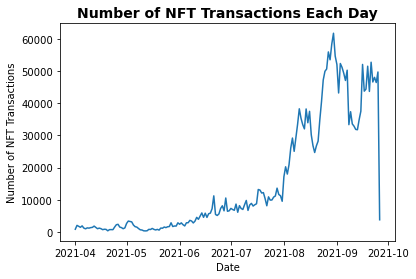

In [140]:
#plot 
plt.plot(df2['count'])
plt.xlabel('Date')
plt.ylabel('Number of NFT Transactions')
plt.title('Number of NFT Transactions Each Day', weight='bold', fontsize=14 )

The number of transactions grew quite rapidly in Q2 and Q3 of 2021. 

# How Does Transaction Value Change With Each Transfer?

In [90]:
transfers_df = ds.load_dataframe("transfers")

In [91]:
#removing transactions worth 0 ETH because 'they may include on-chain transactions that were paid with off-chain assets orthey may purely be a gift' - PwC
transfers_df1 = transfers_df[transfers_df['transaction_value'] != 0]

In [92]:
#select nft/token combos that have been transferred 5 or more times 
trans_count = transfers_df1.groupby(['nft_address', 'token_id'])['token_id'].count()
trans_count = trans_count.to_frame()
trans_count = trans_count.rename(columns={'token_id': 'count'})
trans_count.reset_index(inplace=True)
trans_5 = trans_count[trans_count['count'] >= 5]

In [93]:
tran_rep = transfers_df1.sort_values(['nft_address', 'token_id']).copy()

In [94]:
trans_5 = trans_5.sort_values(['nft_address', 'token_id'])

In [95]:
#all data for nfts that were transferred 5 or more times 
joined = pd.merge(tran_rep, trans_5, on=['nft_address', 'token_id'], how='right')

In [96]:
#find averages for the transaction values for the first 5 times an nft was transferred
joined= joined.sort_values(['nft_address', 'token_id', 'timestamp'])

In [97]:
joined['Counter'] = joined.groupby(['nft_address', 'token_id']).cumcount()+1
joined = joined.drop('count', axis=1)

In [98]:
avg1 = joined[joined['Counter'] == 1]['transaction_value'].mean()
avg2 = joined[joined['Counter'] == 2]['transaction_value'].mean()
avg3 = joined[joined['Counter'] == 3]['transaction_value'].mean()
avg4 = joined[joined['Counter'] == 4]['transaction_value'].mean()
avg5 = joined[joined['Counter'] == 5]['transaction_value'].mean()


([<matplotlib.axis.XTick at 0x29663d0a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

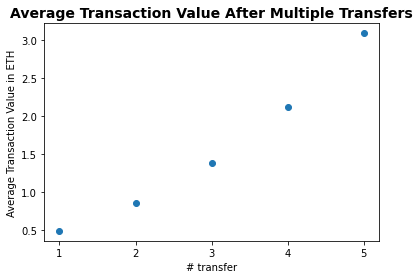

In [103]:
#plot 
x = [1, 2, 3, 4, 5]
y = [avg1, avg2, avg3, avg4, avg5]
y = [item/10**18 for item in y]
plt.scatter(x, y)
plt.xlabel('# transfer')
plt.ylabel('Average Transaction Value in ETH')
plt.title('Average Transaction Value After Multiple Transfers', weight='bold', fontsize = 14)
plt.xticks( range(1,6,1) )

In [101]:
print(avg1/10**18)
print(avg2/10**18)
print(avg3/10**18)
print(avg4/10**18)
print(avg5/10**18)

0.49209170727236945
0.8574284923410727
1.382205155013636
2.123821457402826
3.086148205116261


Plot shows that NFT value increases each time it is transfered. This suggests that valuable NFTs are transfered more often. 





# Are There NFTs That Lose Value Over Time?

In [263]:
joined.reset_index(inplace=True)

In [167]:
difference = joined['transaction_value'].diff()
joined['value_difference'] = difference
joined.loc[joined.Counter == 1, 'value_difference'] = 0

In [168]:
joined['depreciated'] = [0] * 71384
joined.loc[joined.value_difference < 0, 'depreciated'] = True
joined.loc[joined.value_difference >= 0, 'depreciated'] = False

In [193]:
grouped_dep = joined.groupby(['nft_address', 'token_id'])['depreciated'].sum()
grouped_dep = grouped_dep.to_frame()
grouped_dep.reset_index(inplace=True)
grouped_count = joined.groupby(['nft_address', 'token_id']).size()
grouped_count = grouped_count.to_frame()
grouped_count.reset_index(inplace=True)
grouped_count.columns = ['nft_address', 'token_id', 'num_trans']

In [200]:
grouped = pd.merge(grouped_count, grouped_dep, on=['nft_address', 'token_id'] )

In [201]:
grouped_over_half = grouped[grouped['depreciated'] > grouped['num_trans']//2 ]

In [254]:
collections = grouped_over_half.groupby('nft_address').size().to_frame()
collections.reset_index(inplace=True)
collections.columns = ['nft_address', 'count']
collections.sort_values('count', ascending=False, inplace=True)
col_40 = collections.iloc[0:40, :].copy()
col_40['type'] = ['art','art', 'text', 'art', 'art', 'avatar', 'art', 'art','DAO','avatar', 'membership', 'art', 'avatar', 'membership', 'membership', 'art', 'art', 'membership', 'art', 'text', 'membership', 'art', 'art', 'charity', 'membership', 'art', 'art', 'art', 'art', 'DAO', 'text', 'art', 'avatar', 'text', 'art', 'art', 'art', 'art', 'art', 'art']

         type  count
1         art     23
4  membership      6
2      avatar      4
5        text      4
0         DAO      2
3     charity      1


Text(0.5, 1.0, 'Types of NFT Collections That Consistently Lost Value When Transferred (Top 40)')

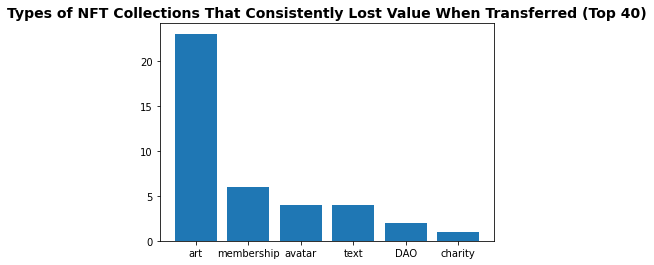

In [264]:
coll_count = col_40.groupby('type')['type'].count().to_frame()
coll_count.columns = ['count']
coll_count.reset_index(inplace=True)
coll_count.sort_values('count', ascending=False, inplace=True)
print(coll_count)
plt.bar(coll_count['type'], coll_count['count'])
plt.title('Types of NFT Collections That Consistently Lost Value When Transferred (Top 40)', weight='bold', fontsize=14)

This is difficult to draw real conclusions from, since majority of NFT collections are art collections and the global proportions are unknown. These categories were found manually and have some overlap as well (especially between art and membership). I attempted to find other correlations between the collections that lost value between transactions but could not find any. Another aspect to explore will be the relation of time to depreciation.  

# What Amount of Mints Are Actually Sold?  

In [36]:
mints_df = ds.load_dataframe("mints")

In [122]:
mints_df

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp
0,6c6d226e-2096-4b50-ac3f-f7078ca3a0c2,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3223,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
1,263c923f-4db9-4d81-a547-27e1fe5ec405,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5077,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
2,8baa8502-42f9-453e-824a-ad504045c9c5,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5070,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
3,364ee658-ff31-4d0a-a7a7-60d3d7822772,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3757,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933
4,58d3adc3-03d2-4e7b-b02c-47957c1f5752,0xd44be17c0298717ce001843069b0a2ca08b577fa2b33...,12936414,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,3252202771441387673917605047769619801375983664...,0x0000000000000000000000000000000000000000,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,2.251726e+15,1627776925
...,...,...,...,...,...,...,...,...,...
6667277,83c90d6c-4ac8-4848-9037-552f3130ba71,0x9af041dbe1c586e705d96bc9a30a9c1dce38644f54e4...,12545208,0x375ea781c49EaFEdDE07AFe6196f885761f166Ae,17217,0x0000000000000000000000000000000000000000,0xf459B83f676467e55Ed557a45B1E64569450F051,1.000000e+18,1622505415
6667278,ada32bbd-bdc0-498c-9150-1d4514987dd1,0x9af041dbe1c586e705d96bc9a30a9c1dce38644f54e4...,12545208,0x375ea781c49EaFEdDE07AFe6196f885761f166Ae,17218,0x0000000000000000000000000000000000000000,0xf459B83f676467e55Ed557a45B1E64569450F051,1.000000e+18,1622505415
6667279,ce45c59b-f79d-49cf-9087-cb216705c970,0x9af041dbe1c586e705d96bc9a30a9c1dce38644f54e4...,12545208,0x375ea781c49EaFEdDE07AFe6196f885761f166Ae,17219,0x0000000000000000000000000000000000000000,0xf459B83f676467e55Ed557a45B1E64569450F051,1.000000e+18,1622505415
6667280,3eba4e0a-42aa-482e-882a-2b81dc399c1b,0x9af041dbe1c586e705d96bc9a30a9c1dce38644f54e4...,12545208,0x375ea781c49EaFEdDE07AFe6196f885761f166Ae,17220,0x0000000000000000000000000000000000000000,0xf459B83f676467e55Ed557a45B1E64569450F051,1.000000e+18,1622505415


In [ ]:
nfts_df = ds.load_dataframe("nfts")

In [9]:
nfts_df

,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES
...,...,...,...
9383,0x848433E170d7b253e8004415643260f18e36fA40,Fredrick and Penny,FNPBJ
9384,0xb5dc78d106cb4540ca945DC1fabC63845198f3F0,SH Minter,SH
9385,0x053bf84359415542E9d65138d1bC0dD0d01e10F7,NFT - 3,NFT3
9386,0xc1a8621eFdeF8E2173435Af416ac18D858ECaF49,Pedro Ferreira,PF


In [37]:
tran = transfers_df.iloc[:, 3:5].drop_duplicates()
mi2 = mints_df.merge(tran, on=['nft_address', 'token_id'],
                  how='left', indicator=True)

In [38]:
unminted = mi2[mi2['_merge']=='left_only']

In [111]:
print("Number of mints that were not transfered:", len(unminted))

Number of mints that were not transfered: 4160796


Text(0.5, 1.0, 'Proportion of Mints That Went Untransferred')

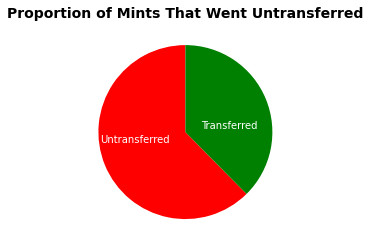

In [129]:
pie = [4160796/6667282, 2506486/6667282]
labels = ['Untransferred \n 62.4%', 'Transferred /n 37.6%']
plt.pie(pie, labels=labels, colors=['red', 'green'], labeldistance=.2, startangle=90, textprops = {'color':'white'})
plt.title("Proportion of Mints That Went Untransferred", weight='bold', fontsize = 14)

# What Does the First Transfer After Minting Look Like?

In [39]:
transferred_mints = mi2[mi2["_merge"] == 'both']
transferred_mints = transferred_mints.rename(columns = {'timestamp':'minttimestamp'})

In [40]:
transferred_mints.drop('_merge', axis=1, inplace=True)

In [41]:
transfers_ = transfers_df.sort_values(['nft_address', 'token_id', 'timestamp']).copy()
transfers_['Counter'] = transfers_.groupby(['nft_address', 'token_id']).cumcount()+1
first_transfer = transfers_[transfers_['Counter']==1]
first_transfer = first_transfer.rename(columns = {'timestamp':'transfertimestamp'})


In [42]:
mint_time = pd.merge(first_transfer, transferred_mints, on=['nft_address', 'token_id'], how='left', indicator = True)
mint_time = mint_time[mint_time['_merge'] == 'both']

In [43]:
sold = mint_time[mint_time['transaction_value_x'] != 0]

In [44]:
sold = sold.copy()

In [45]:
sold = sold.assign(timeToSell=sold['transfertimestamp'] - sold['minttimestamp'])

In [23]:
print("On average, NFTs took", sold['timeToSell'].mean()/86400, "days after minting to sell")

On average, NFTs took 6.975507915879865 days after minting to sell


In [46]:
sold_nooutliers = sold[(np.abs(stats.zscore(sold['transaction_value_x'])) < 3)].copy()
sold_nooutliers = sold_nooutliers[sold_nooutliers['transfertimestamp'] >= 0 ].copy()

In [47]:
sold_nooutliers = sold_nooutliers[sold_nooutliers['timeToSell'] >= 0 ].copy()

In [48]:
quantiles = sold_nooutliers.timeToSell.quantile([0.25,0.5,0.75]).to_list()
quantiles.append(max(sold_nooutliers['timeToSell']))
quantiles.append(min(sold_nooutliers['timeToSell']))
quantiles.sort()

In [49]:
sold_q1 = sold_nooutliers[sold_nooutliers['timeToSell'] < 6676]
sold_q2 = sold_nooutliers[(sold_nooutliers['timeToSell'] < 88180) & (sold_nooutliers['timeToSell'] >= 6676)]
sold_q3 = sold_nooutliers[(sold_nooutliers['timeToSell'] >= 88180) & (sold_nooutliers['timeToSell'] < 536746)]
sold_q4 = sold_nooutliers[sold_nooutliers['timeToSell'] >= 536746]

{'whiskers': [<matplotlib.lines.Line2D at 0x1dbd40b80>,
 'caps': [<matplotlib.lines.Line2D at 0x1d9672280>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dbd40820>],
 'medians': [<matplotlib.lines.Line2D at 0x1d9672940>],
 'fliers': [<matplotlib.lines.Line2D at 0x1d9672ca0>],
 'means': []}

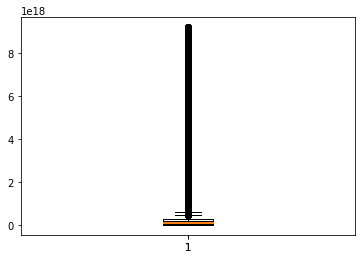

In [82]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
ax = data[['Box1', 'Box2']].plot(kind='box', title='boxplot')
ax.boxplot(sold_q1['transaction_value_x'])
ax.boxplot(sold_q2['transaction_value_x'])

#plt.boxplot(sold_q1['transaction_value_x'], showfliers=False)
#plt.boxplot(sold_q2['transaction_value_x'], showfliers=False)

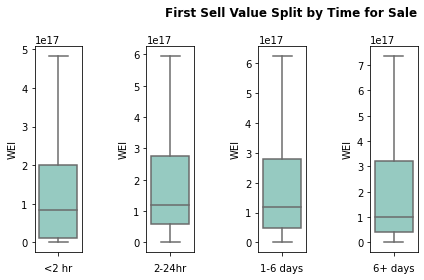

In [67]:
import seaborn as sns
f, axes = plt.subplots(1, 4)
sns.boxplot(y='transaction_value_x', data=sold_q1, palette="Set3",ax=axes[0], showfliers=False)

sns.boxplot(y='transaction_value_x', data=sold_q2, palette="Set3",ax=axes[1], showfliers=False)

sns.boxplot(y='transaction_value_x', data=sold_q3, palette="Set3",ax=axes[2], showfliers=False)

sns.boxplot(y='transaction_value_x', data=sold_q4, palette="Set3",ax=axes[3], showfliers=False)
axes[0].set_ylabel('WEI')
axes[1].set_ylabel('WEI')
axes[2].set_ylabel('WEI')
axes[3].set_ylabel('WEI')
axes[0].set_xlabel('<2 hr')
axes[1].set_xlabel('2-24hr')
axes[2].set_xlabel('1-6 days')
axes[3].set_xlabel('6+ days')
plt.title('First Sell Value Split by Time for Sale', pad=30, weight='bold', loc='right')
plt.tight_layout()
plt.show()

In [108]:
avg1 = sold_q1['transaction_value_x'].mean()
avg2 = sold_q2['transaction_value_x'].mean()
avg3 = sold_q3['transaction_value_x'].mean()
avg4 = sold_q4['transaction_value_x'].mean()


Text(0.5, 1.0, 'Average Transaction Value When NFT is Transfered First Time')

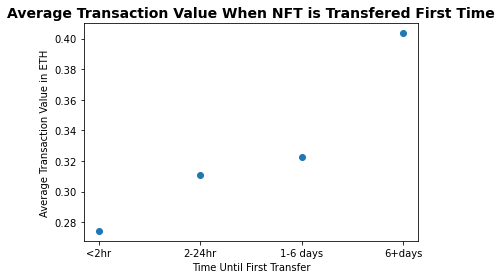

In [113]:
x = ['<2hr', '2-24hr', '1-6 days', '6+days']
y = [avg1, avg2, avg3, avg4]
y = [item/10**18 for item in y]
plt.scatter(x, y)
plt.xlabel('Time Until First Transfer')
plt.ylabel('Average Transaction Value in ETH')
plt.title('Average Transaction Value When NFT is Transfered First Time', weight='bold', fontsize = 14)
#plt.xticks( range(1,5,1) )

In [115]:
med1 = sold_q1['transaction_value_x'].median()
med2 = sold_q2['transaction_value_x'].median()
med3 = sold_q3['transaction_value_x'].median()
med4 = sold_q4['transaction_value_x'].median()

Text(0.5, 1.0, 'Median Transaction Value When NFT is Transfered First Time')

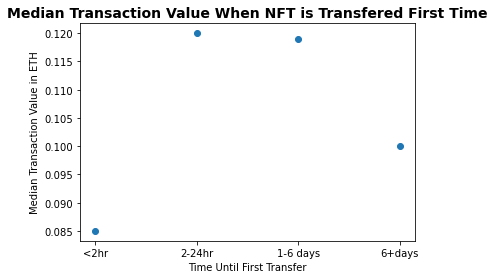

In [116]:
x = ['<2hr', '2-24hr', '1-6 days', '6+days']
y = [med1, med2, med3, med4]
y = [item/10**18 for item in y]
plt.scatter(x, y)
plt.xlabel('Time Until First Transfer')
plt.ylabel('Median Transaction Value in ETH')
plt.title('Median Transaction Value When NFT is Transfered First Time', weight='bold', fontsize = 14)
#plt.xticks( range(1,5,1) )

In [120]:
sold.sort_values('transaction_value_x')

,event_id_x,transaction_hash_x,block_number_x,nft_address,token_id,from_address_x,to_address_x,transaction_value_x,transfertimestamp,Counter,event_id_y,transaction_hash_y,block_number_y,from_address_y,to_address_y,transaction_value_y,minttimestamp,_merge,timeToSell
1383194,cd052236-b70a-476b-80f3-ab52c194b941,0x822bc4bb27c50697f8bd4610aecb1bf7d61bf697f4f4...,13068343,0x66779f4615f287b4DB421b7910620E05daaE79B9,188,0x0Ca338955087E3Fe5D968116028638720473D241,0x36740817E4b6ee7e95f1c406d9b282EF72E3f0b9,1.000000e+00,1629545368,1,3b0cabb8-2d21-4de7-a8dd-80e1019bdc0a,0x775d4b8e3ff3c6caf4edf0e32338151d42e24d76cf87...,12900903.0,0x0000000000000000000000000000000000000000,0x0Ca338955087E3Fe5D968116028638720473D241,0.000000e+00,1.627290e+09,both,2255686.0
419688,2191d6c5-faff-4a0d-ba81-faa8e982d9a2,0xe536a82fb52e1b2d1423d3f0d4b7cd7eb19f77357209...,13068409,0x2C9476716ee3eE590BcdF9827dbd792b79480d4a,2,0xF4217855a4d52fedd25759683BFCf6668B3dc362,0x36740817E4b6ee7e95f1c406d9b282EF72E3f0b9,1.000000e+00,1629546318,1,15616e62-bd90-4bb7-8e47-bb3d7fae1b81,0x8115d77ab8923044ec602e1136291d21b28176d6ad20...,12472323.0,0x0000000000000000000000000000000000000000,0xF4217855a4d52fedd25759683BFCf6668B3dc362,0.000000e+00,1.621528e+09,both,8018490.0
2534825,a7dc95e1-af0c-4597-a925-3dfe48be9426,0xe3faa2ef3e2e135cc587a38c322f8dd4aa38df73b663...,12632646,0xbf98F29a900dE1Aa2722C37FC412fb60c65f0af9,3,0xbf98F29a900dE1Aa2722C37FC412fb60c65f0af9,0xb9cAffD604Ee8bD3FFdd3a2a94bF2a523E52043C,1.000000e+00,1623674839,1,57e3e9e8-b976-4040-9d6d-9193692c3fd4,0xa6684b3b3ac8992266705e212165a737b0af3f96694d...,12632541.0,0x0000000000000000000000000000000000000000,0xbf98F29a900dE1Aa2722C37FC412fb60c65f0af9,0.000000e+00,1.623674e+09,both,1338.0
2212062,04038ee7-aad9-42ac-b35a-629e44ce836c,0xf7ef3c21ddd09fca6b90342d0a5ebca7b7a365d0c887...,13008272,0xF2212d6624e99f4f7E7c5a293Fc2f1293C6D3b47,2,0x4f05e5985e1D38f6810f456b3AAaF8cDc7807997,0x30ab1ba4dA05366c5153A02f8F494c9EFa469369,2.000000e+00,1628743469,1,3ead46b1-1662-4668-b6e3-694adf30bacc,0xf7ef3c21ddd09fca6b90342d0a5ebca7b7a365d0c887...,13008272.0,0x0000000000000000000000000000000000000000,0x4f05e5985e1D38f6810f456b3AAaF8cDc7807997,2.000000e+00,1.628743e+09,both,0.0
2212063,f32db2b9-27ff-4509-855c-428421baf43b,0xf7ef3c21ddd09fca6b90342d0a5ebca7b7a365d0c887...,13008272,0xF2212d6624e99f4f7E7c5a293Fc2f1293C6D3b47,3,0x4f05e5985e1D38f6810f456b3AAaF8cDc7807997,0x30ab1ba4dA05366c5153A02f8F494c9EFa469369,2.000000e+00,1628743469,1,ae2a7979-2788-4688-8625-3a259ff74004,0xf7ef3c21ddd09fca6b90342d0a5ebca7b7a365d0c887...,13008272.0,0x0000000000000000000000000000000000000000,0x4f05e5985e1D38f6810f456b3AAaF8cDc7807997,2.000000e+00,1.628743e+09,both,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552675,f7c3409d-18ea-4d37-bbda-f8ee547074d2,0xeb3e7d6fc2c826f4828084af2c8720914f7f7aedfabf...,13127654,0x371020c4a69457935584F68000E4F883e4e8Ed98,40,0x84D34f4f83a87596Cd3FB6887cFf8F17Bf5A7B83,0x1c1919Ec9de318b58fA66baE7449438C673E10B8,5.500025e+20,1630336867,1,c4bcc31b-d6ff-4295-a9be-0439ecaaffc9,0x178190ab7692aaf0f54e8db4965cad2bef018e8ca91f...,13031339.0,0x0000000000000000000000000000000000000000,0x84D34f4f83a87596Cd3FB6887cFf8F17Bf5A7B83,0.000000e+00,1.629052e+09,both,1285314.0
2482341,9b87af97-3757-428b-b45c-e09565254210,0x6568317017d8722ecff2d2be77c2ddcc53e827541d86...,12205115,0xb932a70A57673d89f4acfFBE830E8ed7f75Fb9e0,23154,0x45Fa9AB78aE37fbB282F8069b49765ECAa04c0e7,0x0bD3D88aec644c098574C881c25e963d9f57CA57,6.180000e+20,1617964092,1,5437de1d-2e71-4ed0-8152-4b164dd1a7be,0x01e04c2f9af7a2d28c01ff1e903427b668914a611a4c...,12205074.0,0x0000000000000000000000000000000000000000,0x45Fa9AB78aE37fbB282F8069b49765ECAa04c0e7,0.000000e+00,1.617964e+09,both,455.0
1522265,b2dfe27e-f6f8-475b-897c-30ab1d027d01,0x99f1872f2a7bbd1e36910beed2d639378ebd3e747418...,12796259,0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7,17522,0x12e5E3E7A1389feD96e1BE50aEd32316C027B18B,0x005E9EeD36BfEA0D05c0e8f36f32d4f4E08EFacd,1.000000e+21,1625875170,1,a